# W261 Final Project - Experiment, Fine-Tune, Select the Optimal Pipeline (Coding Notebook - Logistics Baseline Model)
## Section 02, Team 1: Aimee, Dylan, Jo, Vicky

In [0]:
# read datasets
section = "02"
number = "01"
folder_path = f"dbfs:/student-groups/Group_{section}_{number}"

# Read the checkpointed train and test datasets
df_train_downsampled = spark.read.parquet(f"{folder_path}/df_train_downsampled.parquet")
df_test = spark.read.parquet(f"{folder_path}/df_test.parquet")
df_train = spark.read.parquet(f"{folder_path}/df_train.parquet")

# Setup & Directory

In [0]:
# Basic Functions
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import isnan, when, count, col, isnull, percent_rank
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType
 
# For feature engineering
from pyspark.ml.feature import StandardScaler, VectorAssembler, VectorIndexer, StringIndexer, OneHotEncoder, ChiSqSelector, Bucketizer, Imputer, MinMaxScaler,FeatureHasher
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.window import Window
from pyspark.streaming import StreamingContext
from pyspark.sql import Row
from functools import reduce
from pyspark.sql.functions import rand,col,when,concat,substring,lit,udf,lower,sum as ps_sum,count as ps_count,row_number
from pyspark.sql.window import *
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler,BucketedRandomProjectionLSH,VectorSlicer
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.sql.functions import array, create_map, struct
from itertools import product
 
# For EDA/plotting & basic funcs
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 200)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1, style='whitegrid')
import random
from math import floor
 
# For Modeling
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC, RandomForestClassifier, GBTClassifier, NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from sklearn.metrics import classification_report
import itertools 
from xgboost.spark import SparkXGBClassifier

In [0]:
# read datasets
section = "02"
number = "01"
folder_path = f"dbfs:/student-groups/Group_{section}_{number}"

df_otpw_60m = spark.read.parquet(f"{folder_path}/otpw_60m_proceed.parquet")

In [0]:
print(df_train_downsampled.filter(F.col("HourlyPrecipitation").isNull()).count())
print(df_train_downsampled.filter(F.col("HourlySeaLevelPressure").isNull()).count())
print(df_train_downsampled.filter(F.col("HourlyWindGustSpeed").isNull()).count())

0
0
0


In [0]:
# print the size of df_otpw_60m dataset before dropping duplicates
print("Size of df_otpw_60m:", df_otpw_60m.count())

# drop duplicates in df_otpw_60m dataset
df_otpw_60m = df_otpw_60m.dropDuplicates()

# print the size of df_otpw_60m dataset after dropping duplicates
print("Size of df_otpw_60m:", df_otpw_60m.count())

Size of df_otpw_60m: 31179957
Size of df_otpw_60m: 31175565


In [0]:
# print the size of df_otpw_60m dataset before dropping duplicates
print("Size of df_train_downsampled:", df_train_downsampled.count())

# drop duplicates in df_otpw_60m dataset
df_train_downsampled = df_train_downsampled.dropDuplicates()

# print the size of df_otpw_60m dataset after dropping duplicates
print("Size of df_train_downsampled:", df_train_downsampled.count())

Size of df_train_downsampled: 8622415
Size of df_train_downsampled: 8622415


Our primary customer is the consumer.  As a result, we will focus on predicting departure delays (no delay), where a delay is defined as a 15-minute delay (or greater) concerning the planned departure time. This prediction should be made two hours before departure (thereby giving airlines and airports time to regroup and give passengers a heads-up on a delay). You need to decide how to tackle the problem, either as a Regression problem or as a Classification problem. You need to select which metric should you focus on: F1-Beta, sensitivity, specificity, MSE, R2, etc.


Create machine learning baseline pipelines using logistic/linear regression and ensemble models and do experiments on  the following:
 - Three-month ATPW dataset (this is optional but is a great stepping stone towards the one-year dataset)
 - One-year ATPW dataset
 - Log and report on experimental results (with a primary focus on the one-year ATPW dataset)
     - For the one-year ATPW dataset, please use the last quarter of the available one-year dataset as a blind test set that is never consulted during training. --> train-test split: 75%/25%
     - Report  evaluation metrics in terms of **cross-fold validation** over the training set (first three-quarters of the one-year of ATPW dataset)
     - Report evaluation metrics in terms of the blind test set.
- Discuss experimental results and main findings




Train/test/validation set

Create machine learning baseline pipelines using logistic/linear regression and ensemble models and do experiments on  the following:

- One-year ATPW dataset
- Log and report on experimental results (with a primary focus on the one-year ATPW dataset)
- For the one-year ATPW dataset, please use the last quarter of the available one-year dataset as a blind test set that is never consulted during training.
Report  evaluation metrics in terms of cross-fold validation over the training set (first three-quarters of the one-year of ATPW dataset)


Report evaluation metrics in terms of the blind test set.

Discuss experimental results and main findings.

Fine-tune your baseline pipeline using a grid search
Is there a difference in performance? Is it related to features? Is it related to noise? What is impacting the model performance?

In [0]:
df_otpw_60m.dtypes

[('DEST', 'string'),
 ('ORIGIN', 'string'),
 ('OP_CARRIER_AIRLINE_ID', 'string'),
 ('ORIGIN_STATE_ABR', 'string'),
 ('DEST_STATE_ABR', 'string'),
 ('DEP_DEL15', 'int'),
 ('DIVERTED', 'string'),
 ('DISTANCE_GROUP', 'string'),
 ('MONTH', 'string'),
 ('origin_type', 'string'),
 ('dest_type', 'string'),
 ('dest_airport_lat', 'double'),
 ('dest_airport_lon', 'double'),
 ('sched_depart_date_time_UTC', 'timestamp'),
 ('HourlyDryBulbTemperature', 'double'),
 ('HourlyPrecipitation', 'double'),
 ('HourlyPressureChange', 'double'),
 ('HourlyPressureTendency', 'double'),
 ('HourlyRelativeHumidity', 'double'),
 ('HourlySeaLevelPressure', 'double'),
 ('HourlyStationPressure', 'double'),
 ('HourlyVisibility', 'double'),
 ('HourlyWindGustSpeed', 'double'),
 ('HourlyWindSpeed', 'double'),
 ('prev_flight_delay_ind', 'int'),
 ('is_holiday', 'int'),
 ('is_weekend', 'int'),
 ('origin_pagerank', 'double'),
 ('dest_pagerank', 'double')]

# Logistic Regression

`model = build_model(_alpha=1.0, _l1_ratio=0.3)`

`btscv = BlockingTimeSeriesSplit(n_splits=5)` 

`scores = cross_val_score(model, X_train, y_train, cv=btscv, scoring=r2)`

`print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))`

In [0]:
# count null values per column in df_otpw_3m
# df_3m_nonulls = df_otpw_3m.filter(F.col("cancelled") != 1).dropna().cache()
df_train_downsampled.limit(10).toPandas().head()

,DEST,ORIGIN,OP_CARRIER_AIRLINE_ID,ORIGIN_STATE_ABR,DEST_STATE_ABR,DEP_DEL15,DIVERTED,DISTANCE_GROUP,MONTH,origin_type,dest_type,dest_airport_lat,dest_airport_lon,sched_depart_date_time_UTC,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWindGustSpeed,HourlyWindSpeed,prev_flight_delay_ind,is_holiday,is_weekend,origin_pagerank,dest_pagerank
0,RAP,AZA,20368,AZ,SD,0,0.0,4,5,medium_airport,medium_airport,44.0,-103.1,2018-05-15 00:14:00,84.0,0.003256,0.0023,-1.0,16.0,30.019719,28.370000,20.0,25.23832,6.0,1,0,0,2.508144,0.862933
1,GRI,AZA,20368,AZ,NE,0,0.0,4,5,medium_airport,medium_airport,41.0,-98.3,2018-05-18 13:40:00,82.0,0.003256,0.0023,-1.0,9.0,30.019719,28.370000,45.0,25.23832,7.0,1,0,0,2.508144,0.279927
2,MDT,PIE,20368,FL,PA,0,0.0,4,12,medium_airport,medium_airport,40.2,-76.8,2018-12-10 18:35:00,57.0,0.003256,0.0023,-1.0,72.0,30.090000,29.149112,10.0,25.23832,16.0,1,0,0,2.826869,0.832673
3,FNT,PIE,20368,FL,MI,0,0.0,5,12,medium_airport,medium_airport,43.0,-83.7,2018-12-19 12:50:00,60.0,0.003256,0.0023,-1.0,70.0,30.080000,29.149112,10.0,25.23832,9.0,1,0,0,2.826869,0.873816
4,LAS,FAT,20368,CA,NV,0,0.0,2,6,medium_airport,large_airport,36.1,-115.2,2018-06-22 23:31:00,91.0,0.000000,0.0023,-1.0,23.0,29.740000,29.410000,10.0,25.23832,8.0,0,0,0,0.608583,5.472447


# Define helper Functions

In [0]:
#editing mlp_pipeline() to include new columns
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, FeatureHasher
from pyspark.ml import Pipeline

def mlp_pipeline(model):
    """
    Optimized pipeline for neural network algorithms (MLP).
    """

    # Continuous features
    cont_feat = [
        'dest_airport_lat', 'dest_airport_lon', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 
        'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 
        'HourlyStationPressure', 'HourlyVisibility', 'HourlyWindGustSpeed', 
        'HourlyWindSpeed', 'origin_pagerank', 'dest_pagerank'
    ]

    assembler_cont = VectorAssembler(inputCols=cont_feat, outputCol="cont_features")

    #scale features with MinMaxScaler
    scaler = MinMaxScaler(inputCol="cont_features", outputCol="scaled_features")

    # Categorical features
    columns_categorical = [
        'OP_CARRIER_AIRLINE_ID', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 
        'DIVERTED', 'DISTANCE_GROUP', 'MONTH', 'origin_type', 'dest_type', 'prev_flight_delay_ind', 
        'is_holiday', 'is_weekend'
    ]

    indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid="keep") for c in columns_categorical]

    # Use FeatureHasher
    hasher = FeatureHasher(inputCols=[f"{c}_indexed" for c in columns_categorical], 
                           outputCol="hashed_features", numFeatures=500)

    # Assemble all features in one step
    assembler = VectorAssembler(inputCols=["scaled_features", "hashed_features"], outputCol="features")

    # Define pipeline stages
    stages = [assembler_cont, scaler] + indexers + [hasher, assembler, model]

    pipeline = Pipeline(stages=stages)

    return pipeline

In [0]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, FeatureHasher
from pyspark.ml import Pipeline

def tree_pipeline(model):
    """
    Optimized pipeline for tree-type algorithms (GBT/XGBoost) with updated features.
    """

    # Continuous features (adjusted for your dataset)
    cont_feat = [
        'dest_airport_lat', 'dest_airport_lon', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 
        'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 
        'HourlyStationPressure', 'HourlyVisibility', 'HourlyWindGustSpeed', 
        'HourlyWindSpeed', 'origin_pagerank', 'dest_pagerank'
    ]

    # Assemble continuous features
    assembler_cont = VectorAssembler(inputCols=cont_feat, outputCol="cont_features")

    # Categorical features (updated for your dataset)
    columns_categorical = [
        'OP_CARRIER_AIRLINE_ID', 'ORIGIN', 'ORIGIN_STATE_ABR', 'DEST', 'DEST_STATE_ABR', 
        'DIVERTED', 'DISTANCE_GROUP', 'MONTH', 'origin_type', 'dest_type', 'prev_flight_delay_ind', 'is_holiday', 'is_weekend'
    ]

    # StringIndexer for categorical columns
    indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_indexed", handleInvalid="keep") for c in columns_categorical]

    # Use FeatureHasher for hashing categorical columns
    hasher = FeatureHasher(inputCols=[f"{c}_indexed" for c in columns_categorical], 
                           outputCol="hashed_features", numFeatures=500)

    # Assemble all features into a single vector column
    assembler = VectorAssembler(inputCols=["cont_features", "hashed_features"], outputCol="features")

    # Define the pipeline stages
    stages = [assembler_cont] + indexers + [hasher, assembler, model]

    # Build the pipeline
    pipeline = Pipeline(stages=stages)

    return pipeline


In [0]:
def lr_pipeline(model):
    """
    Pipeline for Logistic regression
    """
    # List of categorical columns to be indexed
    categoricals = ['DEST','ORIGIN','OP_CARRIER_AIRLINE_ID','ORIGIN_STATE_ABR','DEST_STATE_ABR','DIVERTED', 'DISTANCE_GROUP','MONTH', 'origin_type', 'dest_type','prev_flight_delay_ind','is_holiday','is_weekend']

    numerics= ["dest_airport_lat",'dest_airport_lon',"HourlyDryBulbTemperature","HourlyPrecipitation",'HourlyPressureTendency',"HourlyRelativeHumidity","HourlySeaLevelPressure","HourlyStationPressure","HourlyVisibility","HourlyWindGustSpeed","HourlyWindSpeed",'origin_pagerank','dest_pagerank']

    indexers = StringIndexer(inputCols=categoricals,
                             outputCols=[categorical + "_idx" for categorical in categoricals])\
                                 .setHandleInvalid("keep")

    # Use FeatureHasher for hashing categorical columns
    hasher = FeatureHasher(inputCols=[f"{c}_idx" for c in categoricals], 
                           outputCol="hashed_features", numFeatures=500)

    catgorical_assembler = VectorAssembler(inputCols=[categorical + "_idx" for categorical in categoricals],
                                           outputCol="catgorical_features")

    numeric_assembler = VectorAssembler(inputCols=numerics,
                                        outputCol="numeric_features")

    target = StringIndexer(inputCols=["DEP_DEL15"],outputCols=['label'])

    all_features = ["catgorical_features", "numeric_features"]
    
    assembler = VectorAssembler(inputCols=all_features,
                                outputCol="features")

    # Build the stage for the ML pipeline
    stages = [indexers, hasher,catgorical_assembler, numeric_assembler, target, assembler, model]

    # Build our ML pipeline
    pipeline = Pipeline(stages=stages)

    return pipeline

In [0]:
def get_model(model_type, pipeline_func, p):
  """
  Input: name of model, the pipeline function for that model and a set of parameters
  Output: a pipeline object for the input model type
  """
  if model_type == 'gbt':
    gbt = GBTClassifier(labelCol="DEP_DEL15",
                        featuresCol="features",
                        maxDepth=p["maxDepth"],
                        maxBins=p["maxBins"],
                        maxIter=p["maxIter"],
                        stepSize=p["stepSize"])
    pipeline = pipeline_func(gbt)
  elif model_type == 'mlp':
    mlp = MultilayerPerceptronClassifier(labelCol="DEP_DEL15",
        featuresCol="features",
        layers=p["layers"],
        maxIter=p["maxIter"],
        blockSize=p["blockSize"],
        seed=p["seed"])
    pipeline = pipeline_func(mlp)
    return pipeline
  elif model_type == 'xgboost':
    xgboost = SparkXGBClassifier(
        label_col="DEP_DEL15",  # Ensure this is the target column for classification (binary or multi-class labels)
        features_col="features",  # The feature column
        missing=0.0,
        raw_prediction_col='probability',  # This is for storing the prediction probabilities in classification tasks
        max_depth=p["max_depth"],
        n_estimators=p["n_estimators"],
        reg_lambda=p["reg_lambda"],
        reg_alpha=p["reg_alpha"],
        base_score=p["base_score"],
        learning_rate=p["learning_rate"],
        gamma=p["gamma"],
        min_child_weight=p["min_child_weight"],
        tree_method=p["tree_method"],  
        num_workers=p["num_workers"]   
    )
    pipeline = pipeline_func(xgboost)

  elif model_type == 'lr':
      # Use logistic regression 
      lr = LogisticRegression(maxIter=p['maxIter'],
                              elasticNetParam=p['elasticNetParam'],
                              regParam=p['regParam'],
                              featuresCol="features",
                              labelCol='label')
      
      pipeline = pipeline_func(lr)
      
    
  return pipeline

In [0]:
def evaluate_classification_model(prediction, label_col="DEP_DEL15", prediction_col="prediction"):
    
    # Select predictions and actual labels
    predictions_and_labels = prediction.select(prediction_col, label_col)

    # For binary classification (precision, recall, F1):
    binary_evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol=prediction_col)
    
    # Calculate True Positives, False Positives, True Negatives, and False Negatives
    TP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 1)).count()  # True Positive
    FP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 0)).count()  # False Positive
    TN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 0)).count()  # True Negative
    FN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 1)).count()  # False Negative
    
    # Calculate evaluation metrics
    beta = 2
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) != 0 else 0.0
    roc_auc = binary_evaluator.setMetricName("areaUnderROC").evaluate(prediction)
    pr_auc = binary_evaluator.setMetricName("areaUnderPR").evaluate(prediction)

    # Create confusion matrix as a 2x2 array
    conf_matrix = np.array([[TN, FP], 
                            [FN, TP]])

    # Convert to Pandas DataFrame
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                index=["Actual Negative (0)", "Actual Positive (1)"], 
                                columns=["Predicted Negative (0)", "Predicted Positive (1)"])

    # Plot the confusion matrix with color bar
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=True)  # cbar=True adds side bar
    plt.title("Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()
    
    return precision, recall, f1_score, f2_score, roc_auc, pr_auc

In [0]:
def evaluate_classification_model_train_test(prediction, label_col="DEP_DEL15", prediction_col="prediction",evaluation_type="train"):
    
    # Select predictions and actual labels
    predictions_and_labels = prediction.select(prediction_col, label_col)

    # For binary classification (precision, recall, F1):
    binary_evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol=prediction_col)
    
    # Calculate True Positives, False Positives, True Negatives, and False Negatives
    TP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 1)).count()  # True Positive
    FP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 0)).count()  # False Positive
    TN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 0)).count()  # True Negative
    FN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 1)).count()  # False Negative
    
    # Calculate evaluation metrics
    beta = 2
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) != 0 else 0.0
    roc_auc = binary_evaluator.setMetricName("areaUnderROC").evaluate(prediction)
    pr_auc = binary_evaluator.setMetricName("areaUnderPR").evaluate(prediction)

    # Create confusion matrix as a 2x2 array
    conf_matrix = np.array([[TN, FP], 
                            [FN, TP]])

    # Convert to Pandas DataFrame
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                index=["Actual Negative (0)", "Actual Positive (1)"], 
                                columns=["Predicted Negative (0)", "Predicted Positive (1)"])

    # Plot the confusion matrix with color bar
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=True)  # cbar=True adds side bar
    if evaluation_type == 'train':
        plt.title("Confusion Matrix (Train Set)")
    else:
        plt.title("Confusion Matrix (Test Set)")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()
    
    return precision, recall, f1_score, f2_score, roc_auc, pr_auc

In [0]:
def evaluate_ensembleOfEnsemble_model(prediction, label_col="DEP_DEL15", prediction_col="prediction"):
    
    # Select predictions and actual labels
    predictions_and_labels = prediction.select(prediction_col, label_col)

    # For binary classification (precision, recall, F1):
    binary_evaluator = BinaryClassificationEvaluator(labelCol=label_col, rawPredictionCol=prediction_col)
    
    # Calculate True Positives, False Positives, True Negatives, and False Negatives
    TP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 1)).count()  # True Positive
    FP = predictions_and_labels.filter((col(prediction_col) == 1) & (col(label_col) == 0)).count()  # False Positive
    TN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 0)).count()  # True Negative
    FN = predictions_and_labels.filter((col(prediction_col) == 0) & (col(label_col) == 1)).count()  # False Negative
    
    # Calculate evaluation metrics
    beta = 2
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0
    f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall) if (precision + recall) != 0 else 0.0
    roc_auc = binary_evaluator.setMetricName("areaUnderROC").evaluate(prediction)
    pr_auc = binary_evaluator.setMetricName("areaUnderPR").evaluate(prediction)

    # Create confusion matrix as a 2x2 array
    conf_matrix = np.array([[TN, FP], 
                            [FN, TP]])

    # Convert to Pandas DataFrame
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                index=["Actual Negative (0)", "Actual Positive (1)"], 
                                columns=["Predicted Negative (0)", "Predicted Positive (1)"])

    # Plot the confusion matrix with color bar
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues", cbar=True)  # cbar=True adds side bar
    plt.title("Confusion Matrix")
    plt.ylabel("Actual Label")
    plt.xlabel("Predicted Label")
    plt.show()
    
    return precision, recall, f1_score, f2_score, roc_auc, pr_auc

In [0]:
# Cross-fold Validation

from pyspark.sql import functions as F
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import numpy as np
import pandas as pd

class BlockedTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, df):
        return self.n_splits

    def split(self, df):
        df_sorted = df.orderBy('sched_depart_date_time_UTC').cache()
        timestamps = df_sorted.select("sched_depart_date_time_UTC").rdd.map(lambda r: r[0]).collect()
        n_samples = len(timestamps)
        split_size = n_samples // self.n_splits

        for i in range(self.n_splits):
            start_idx = i * split_size
            stop_idx = min(start_idx + split_size, n_samples)
            mid_idx = start_idx + int(0.8 * (stop_idx - start_idx))

            train_start = timestamps[start_idx]
            train_end = timestamps[mid_idx - 1]
            val_start = timestamps[mid_idx]
            val_end = timestamps[stop_idx - 1]

            train_data = df.filter((F.col("sched_depart_date_time_UTC") >= train_start) &
                                (F.col("sched_depart_date_time_UTC") <= train_end)).cache()

            val_data = df.filter((F.col("sched_depart_date_time_UTC") > train_end) &
                                (F.col("sched_depart_date_time_UTC") <= val_end)).cache()

            yield train_data, val_data


def cross_validate_with_blocked_time_series_split(models, df, n_splits):
    
    evaluator = BinaryClassificationEvaluator(labelCol="DEP_DEL15") 
    
    # Initialize the blocked time series split
    splitter = BlockedTimeSeriesSplit(n_splits)
    
    # Initialize dictionary to store evaluation results
    results = {model_name: {
        "precision": [],
        "recall": [],
        "f1_score": [],
        "f2_score": [],
        "roc_auc": [],
        "pr_auc": []
    } for model_name in models.keys()}
    
    # Cross-validation loop for each model
    for model_name, model in models.items():
        # Perform split and evaluate for each fold
        for train_data, val_data in splitter.split(df):
            # Create a pipeline for training
            pipeline = get_model(model_name, lr_pipeline, model)  
            
            # Train the model using training data
            trained_model = pipeline.fit(train_data)
            
            # Make predictions on validation data
            predictions = trained_model.transform(val_data)
            
            # Evaluate the model with binary classification evaluator
            precision, recall, f1_score, f2_score, roc_auc, pr_auc = evaluate_classification_model(predictions)
            
            # Store the evaluation metrics for each fold
            results[model_name]["precision"].append(precision)
            results[model_name]["recall"].append(recall)
            results[model_name]["f1_score"].append(f1_score)
            results[model_name]["f2_score"].append(f2_score)
            results[model_name]["roc_auc"].append(roc_auc)
            results[model_name]["pr_auc"].append(pr_auc)

        for metric in results[model_name]:
            # Calculate the average of the metric across all folds
            results[model_name][metric] = np.mean(results[model_name][metric])
        
    return results

def cross_validate_with_blocked_time_series_split_ensemble(models, df, n_splits,pred_type):
    
    evaluator = BinaryClassificationEvaluator(labelCol="DEP_DEL15") 
    
    # Initialize the blocked time series split
    splitter = BlockedTimeSeriesSplit(n_splits)
    
    # Initialize dictionary to store evaluation results
    results = {"ensemble": {
        "precision": [],
        "recall": [],
        "f1_score": [],
        "f2_score": [],
        "roc_auc": [],
        "pr_auc": []
    } for model_name in models.keys()}
    
    # Cross-validation loop for each model
    for train_data, val_data in splitter.split(df):
        preds = {}
        val_data = val_data.withColumn("id", monotonically_increasing_id())
        # Perform split and evaluate for each fold
        for model_name, model in models.items():    
            # Make predictions on validation data
            
            preds[model_name] = model.transform(val_data).withColumnRenamed("prediction", f"{model_name}_prediction")
        
        validation_predictions = preds['lr'].select('id','lr_prediction','DEP_DEL15').join(preds['xgb'].select('id','xgb_prediction'), on='id', how='inner').join(preds['mlp'].select('id','mlp_prediction'), on='id', how='inner')
        if pred_type == 'any_prediction':
            validation_predictions = validation_predictions.withColumn("any_prediction", when((col("lr_prediction") == 1) | (col("xgb_prediction") == 1) | (col("mlp_prediction") == 1), 1.0).otherwise(0.0))
            pred_type = "any_prediction"
        elif pred_type == 'majority_prediction':
            validation_predictions = validation_predictions.withColumn("majority_prediction", when((col("lr_prediction") + col("xgb_prediction") + col("mlp_prediction")) >= 2, 1.0).otherwise(0.0))
            pred_type = "majority_prediction"

        

        # Evaluate the model with binary classification evaluator
        precision, recall, f1_score, f2_score, roc_auc, pr_auc = evaluate_ensembleOfEnsemble_model(validation_predictions, label_col="DEP_DEL15", prediction_col=pred_type)
        
        # Store the evaluation metrics for each fold
        results["ensemble"]["precision"].append(precision)
        results["ensemble"]["recall"].append(recall)
        results["ensemble"]["f1_score"].append(f1_score)
        results["ensemble"]["f2_score"].append(f2_score)
        results["ensemble"]["roc_auc"].append(roc_auc)
        results["ensemble"]["pr_auc"].append(pr_auc)

    for metric in results["ensemble"]:
        # Calculate the average of the metric across all folds
        results["ensemble"][metric] = np.mean(results["ensemble"][metric])
        
    return results

In [0]:
print(df_train_downsampled.count())
print(df_train_downsampled.dropna().count())

df_train_downsampled.dropna().count() / df_train_downsampled.count()

8622415
8608790


0.9984198162579742

In [0]:
def timeSeriesSplitCV_old(dataset, param_grid, pipeline_func, model_type, k=3, blocking=False, sampling=None, metric='f2', verbose=True):
  '''
  Perform timSeriesSplit k-fold cross validation 
  '''
  # Initiate trackers
  best_score = 0
  best_param_vals = None
   
  df=dataset
  n=df.count()
  df = df.withColumn("row_id", F.row_number().over(Window.partitionBy().orderBy("sched_depart_date_time_UTC")))
  chunk_size = int(n/(k+1))
  
  parameter_names, parameters = parameter_sets(param_grid)
  print('')
  print(f'Number of validation datapoints for each fold is {chunk_size:,}')
  print("************************************************************")
  
  if len(parameters) == 1:
    print('you only entered one set of parameters you doofus')
  
  for p in parameters:
    p= dict(zip(parameter_names, p))
    pipeline = get_model(model_type, pipeline_func, p)
    
    # Print parameter set
    param_print = {key: value for key, value in p.items()}
    print(f"Parameters: {param_print}")
    
    # Track score
    scores=[]
    
    # Start k-fold
    for i in range(k):
      
      # If TimeseriesSplit 
      if not blocking:
        train_df = df.filter(F.col('row_id') <= chunk_size * (i+1)).cache()
      # If BlockingSplit
      else:
        train_df = df.filter((F.col('row_id') > chunk_size * i)&(F.col('row_id') <= chunk_size * (i+1))).cache()
        
      # Create dev set
      dev_df = df.filter((F.col('row_id') > chunk_size * (i+1))&(F.col('row_id') <= chunk_size * (i+2))).cache()  
        
      #print info on train and dev set for this fold
      if verbose:
        print('    TRAIN set for fold {} goes from {} to {}, count is {:,} flights ({})'.format((i+1), 
              train_df.agg({'DATE':'min'}).collect()[0][0],
              train_df.agg({'DATE':'max'}).collect()[0][0],
              train_df.count(),
              sampling + '-sampled' if sampling else 'no sampling'))
        print('    DEV set for fold {} goes from {} to {}, count is {:,} flights'.format((i+1), 
              dev_df.agg({'DATE':'min'}).collect()[0][0],
              dev_df.agg({'DATE':'max'}).collect()[0][0],
              dev_df.count()))      
      # Fit params on the model
      model = pipeline.fit(train_df)
      dev_pred = model.transform(dev_df)
      if metric == 'f2':
          score = cv_eval(dev_pred, label_col="DEP_DEL15")[0]
      elif metric == 'pr':
          score = cv_eval(dev_pred, label_col="DEP_DEL15")[1]
      scores.append(score)
      print(f'    Number of training datapoints for fold number {i+1} is {train_df.count():,} with a {metric} score of {score:.2f}') 
      print('------------------------------------------------------------')
      # Set best parameter set to current one for first fold
      if best_param_vals == None:
        best_param_vals = p
    
    # Take average of all scores
    avg_score = np.average(scores)    
    # Update best score and parameter set to reflect optimal dev performance
    if avg_score > best_score:
      previous_best = best_score
      best_score = avg_score
      best_parameters = param_print
      best_param_vals = p
      print(f'new best score of {best_score:.2f}')

    else:
      print(f'Result was no better, score was {avg_score:.2f} with best {metric} score {best_score:.2f}')
    print("************************************************************")
  
  # Train on full df
  print('Training on full train dataset, and validating on dev dataset with best parameters from CV:')
  print(best_parameters)

  if verbose:
    print('    TRAIN set for best parameter fitted model goes from {} to {}, count is {:,} flights ({})'.format(train_df.agg({'DATE':'min'}).collect()[0][0],
          train_df.agg({'DATE':'max'}).collect()[0][0],
          train_df.count(),
          sampling + '-sampled' if sampling else 'no sampling'))
  return best_parameters, best_score

In [0]:
from itertools import product

def timeSeriesSplitCV(df, param_grid, pipeline_func, model_type, blocking=True, metric='f2_score'):
    best_params = None
    best_score = -float('inf')

    # Create a list of all combinations from the param grid
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    for i, params in enumerate(param_combinations):
        print("="*80)
        print(f"[{i + 1}/{len(param_combinations)}] Testing parameter combination:")
        for k, v in params.items():
            print(f"  {k}: {v}")

        model_dict = {model_type: params}
        results = cross_validate_with_blocked_time_series_split(model_dict, df, n_splits=3)

        score = results[model_type][metric]
        print(f"  → Selected metric ({metric}): {score:.6f}")

        if score > best_score:
            best_score = score
            best_params = params
            print("New best score!")

    print("="*80)
    print("Best parameter combination found:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print(f"Best {metric}: {best_score:.6f}")
    
    return best_params, best_score


In [0]:

def parameter_sets(param_grid):
    """
    Generates all parameter combinations from a grid of parameters.
    
    Args:
        param_grid (dict): Dictionary where keys are parameter names and values are lists of possible values.

    Returns:
        tuple: (parameter_names, list of parameter combinations)
    """
    parameter_names = list(param_grid.keys())
    # Get cartesian product of all parameter values
    parameters = list(product(*param_grid.values()))
    
    return parameter_names, parameters

In [0]:
def cv_eval(preds, label_col="DEP_DEL15"):
  """
  Input: transformed df with prediction and label
  Output: desired score 
  """
  rdd_preds_m = preds.select(['prediction', label_col]).rdd.map(lambda row: (float(row['prediction']), float(row[label_col])))
  rdd_preds_b = preds.select(label_col, 'probability').rdd.map(lambda row: (float(row['probability'][1]), float(row[label_col])))
  metrics_m = MulticlassMetrics(rdd_preds_m)
  metrics_b = BinaryClassificationMetrics(rdd_preds_b)
  F2 = np.round(metrics_m.fMeasure(label=1.0, beta=2.0), 4)
  pr = metrics_b.areaUnderPR
  return F2, pr

In [0]:
df_train_downsampled = df_train_downsampled.dropna()

# Load Final Logistic Regression Model

In [0]:
%python
# Import the mlflow module
import mlflow

# Load ml model from dbfs:/databricks/mlflow-tracking/1536813829684263/772d71be6767463db23cabcec64011b9/artifacts/model
baseline_model = mlflow.spark.load_model("dbfs:/databricks/mlflow-tracking/1536813829684263/772d71be6767463db23cabcec64011b9/artifacts/model")

# use model to make predictions on df_train_downsampled data
train_predictions_lr = baseline_model.transform(df_train_downsampled)

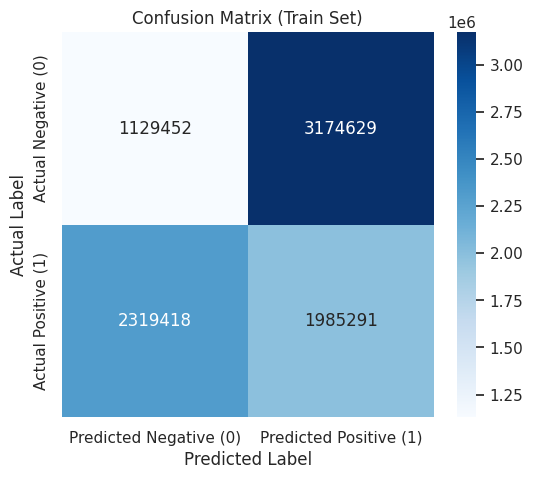

In [0]:
# use model to make predictions on df_train_downsampled data
train_predictions_lr = baseline_model.transform(df_train_downsampled)
precision_train, recall_train, f1_train, f2_train, roc_auc_train, pr_auc_train = evaluate_classification_model_train_test(prediction=train_predictions_lr,evaluation_type='train')

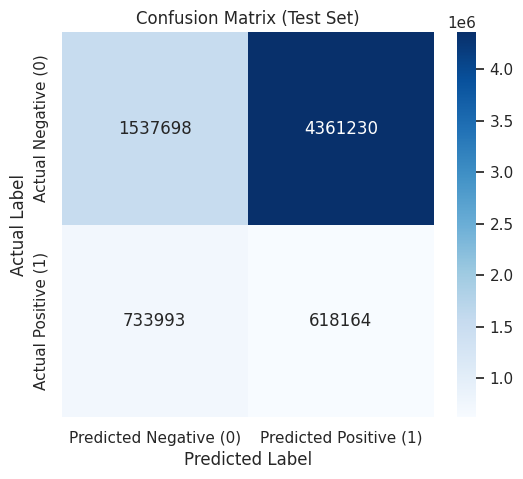

In [0]:
# evaluate model performance on test dataset
test_predictions_lr = baseline_model.transform(df_test.dropna())
precision_test, recall_test, f1_test, f2_test, roc_auc_test, pr_auc_test = evaluate_classification_model_train_test(prediction=test_predictions_lr,evaluation_type='test')

In [0]:
print("Train f2 score",f2_train)
print("Test f2 score",f2_test)

Train f2 score 0.4435659873140402
Test f2 score 0.2975369131871304


In [0]:
# %python
# import time
# import mlflow
# import os

# # Train final model on full training data using XGB
# best_parameters_xgb = {'max_depth': 8, 'n_estimators': 200, 'reg_lambda': 1.0, 'reg_alpha': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'gamma': 1, 'min_child_weight': 5, 'tree_method': 'hist', 'num_workers': 5}
# model_type = 'xgboost'
# pipeline_xgb = get_model(model_type, tree_pipeline, best_parameters_xgb)

# import mlflow.spark

# with mlflow.start_run():
#     xgb_model = pipeline_xgb.fit(df_train_downsampled.dropna())

#     mlflow.spark.log_model(xgb_model, artifact_path="model")


In [0]:
model_uri = "runs:/2972bbcd5d2444db9838dd1017d2cc25/model"
xgb_model = mlflow.spark.load_model(model_uri)

2025/04/18 02:48:10 INFO mlflow.spark: 'runs:/2972bbcd5d2444db9838dd1017d2cc25/model' resolved as 'dbfs:/databricks/mlflow-tracking/3201478130151282/2972bbcd5d2444db9838dd1017d2cc25/artifacts/model'


In [0]:
# xgb_model = mlflow.spark.load_model("dbfs:/databricks/mlflow-tracking/3201478130151282/2972bbcd5d2444db9838dd1017d2cc25/artifacts/model")

# # use model to make predictions on df_train_downsampled data
# train_predictions_xgb = xgb_model.transform(df_train_downsampled)

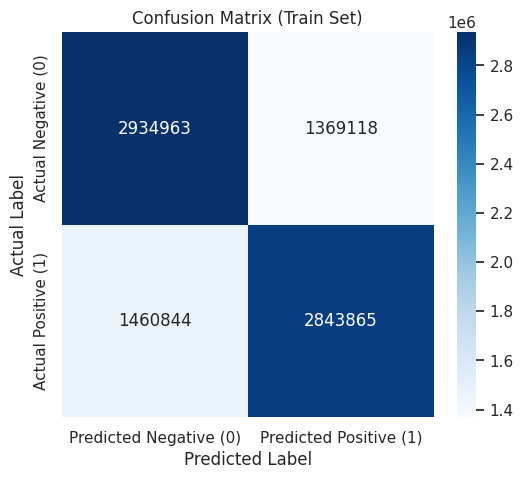

In [0]:
# use model to make predictions on df_train_downsampled data

train_predictions_xgb = xgb_model.transform(df_train_downsampled)
precision_train, recall_train, f1_train, f2_train, roc_auc_train, pr_auc_train = evaluate_classification_model_train_test(prediction=train_predictions_xgb,evaluation_type='train')

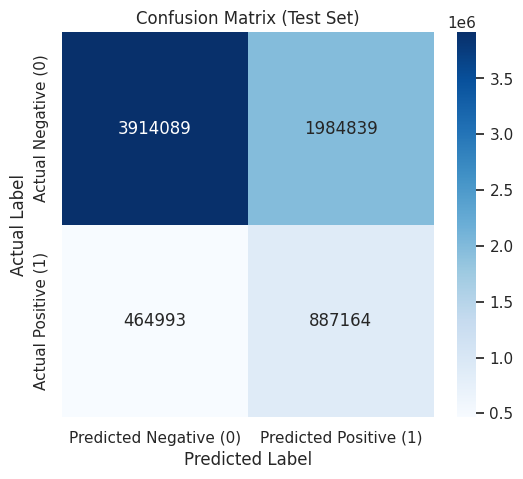

In [0]:
# evaluate model performance on test dataset
test_predictions_xgb = xgb_model.transform(df_test.dropna())
precision_test, recall_test, f1_test, f2_test, roc_auc_test, pr_auc_test = evaluate_classification_model_train_test(prediction=test_predictions_xgb,evaluation_type='test')

In [0]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf, col

def extract_prob(v):
    try:
        return float(v[1])  # Your VectorUDT is of length 2
    except ValueError:
        return None

In [0]:
# raise threshold on test predictions
test_predictions_xgb = xgb_model.transform(df_test.dropna())

# Select the values of the probability column
extract_prob_udf = udf(extract_prob, DoubleType())

test_predictions_xgb = test_predictions_xgb.withColumn("prob_flag", extract_prob_udf(col("probability")))



In [0]:
display(test_predictions_xgb.select("DEP_DEL15",'prob_flag'))

DEP_DEL15,prob_flag
0,0.5227364897727966
0,0.6812083721160889
0,0.5397700071334839
1,0.7235086560249329
0,0.5030506253242493
0,0.36182814836502075
0,0.2874857485294342
0,0.35240063071250916
0,0.35819584131240845
0,0.40478581190109253


In [0]:
print("Train f2 score",f2_train)
print("Test f2 score",f2_test)

Train f2 score 0.6634679492207357
Test f2 score 0.535686229708823


In [0]:
# #training on full 60m dataset
# p = {
#     "maxIter": 50,
#     "layers": [513, 256, 128, 2],  # input, two hidden, output layer
#     "blockSize": 128,
#     "seed": 42
# }
# model_type = 'mlp'
# mlp_pipeline = get_model(model_type, mlp_pipeline, p)

# with mlflow.start_run():
#     mlp_model_60m = mlp_pipeline.fit(df_train_downsampled)

#     mlflow.spark.log_model(mlp_model_60m, artifact_path="model")


In [0]:
model_uri = "runs:/70d0f40542124c929754470ccbac96ae/model"
mlp_model = mlflow.spark.load_model(model_uri)

2025/04/18 02:53:22 INFO mlflow.spark: 'runs:/70d0f40542124c929754470ccbac96ae/model' resolved as 'dbfs:/databricks/mlflow-tracking/3201478130151282/70d0f40542124c929754470ccbac96ae/artifacts/model'


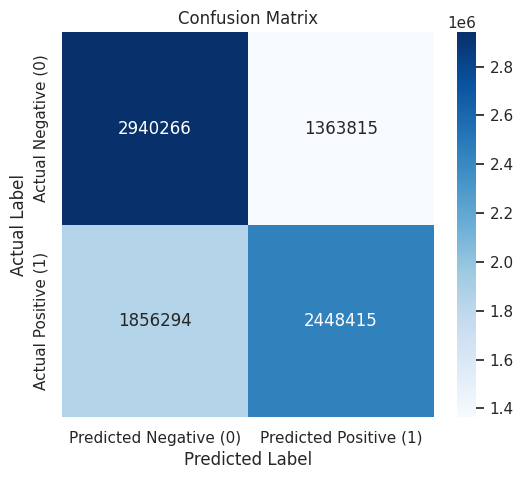

Precision: 0.642252697240198
Recall: 0.5687759613948353
F1 Score: 0.6032853025013493
F2 Score: 0.5820948400808595
ROC AUC: 0.625955204920196
PR AUC: 0.611589170244767


In [0]:
train_predictions = mlp_model.transform(df_train_downsampled)

precision_train, recall_train, f1_score_train, f2_score_train, roc_auc_train, pr_auc_train = evaluate_classification_model(train_predictions, label_col="DEP_DEL15", prediction_col="prediction")

print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_score_train}")
print(f"F2 Score: {f2_score_train}")
print(f"ROC AUC: {roc_auc_train}")
print(f"PR AUC: {pr_auc_train}")

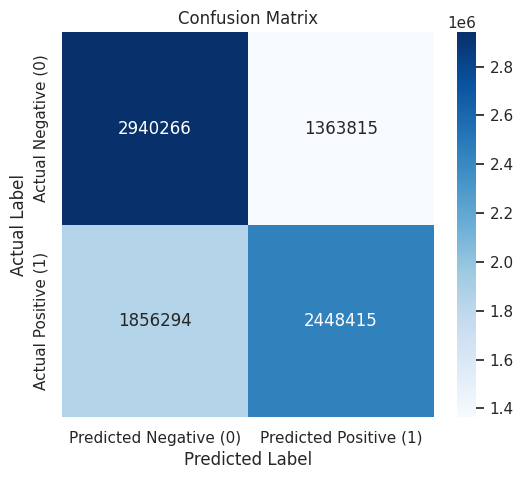

Precision: 0.642252697240198
Recall: 0.5687759613948353
F1 Score: 0.6032853025013493
F2 Score: 0.5820948400808595
ROC AUC: 0.625955204920196
PR AUC: 0.611589170244767


In [0]:
test_predictions = mlp_model.transform(df_test.dropna())

precision_test, recall_test, f1_score_test, f2_score_test, roc_auc_test, pr_auc_test = evaluate_classification_model(train_predictions, label_col="DEP_DEL15", prediction_col="prediction")

print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_score_test}")
print(f"F2 Score: {f2_score_test}")
print(f"ROC AUC: {roc_auc_test}")
print(f"PR AUC: {pr_auc_test}")

# Ensemble Cross Validation

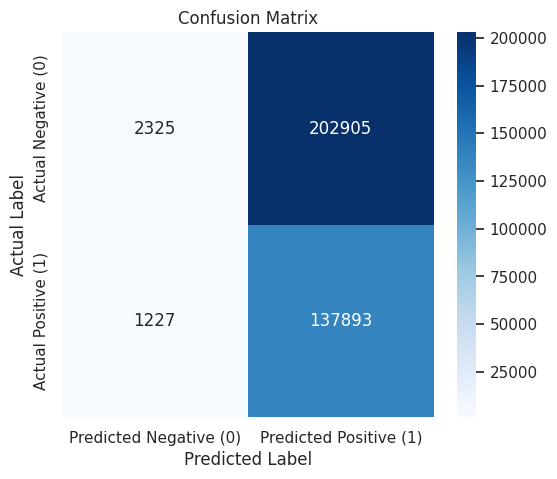

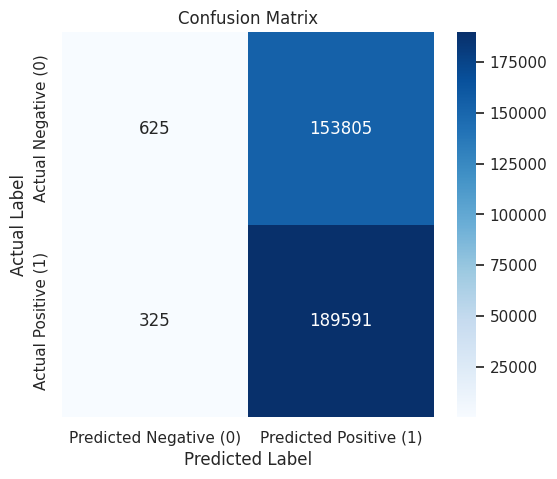

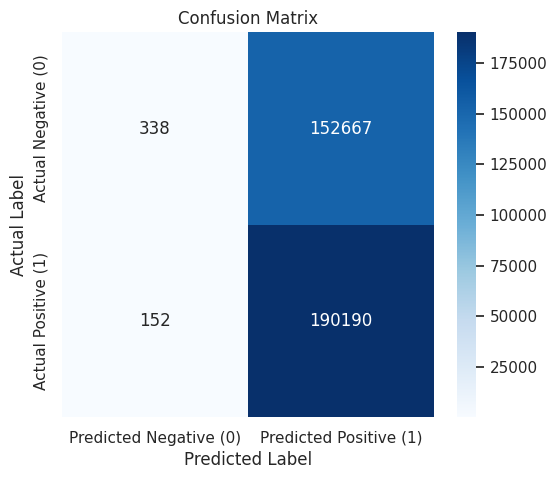

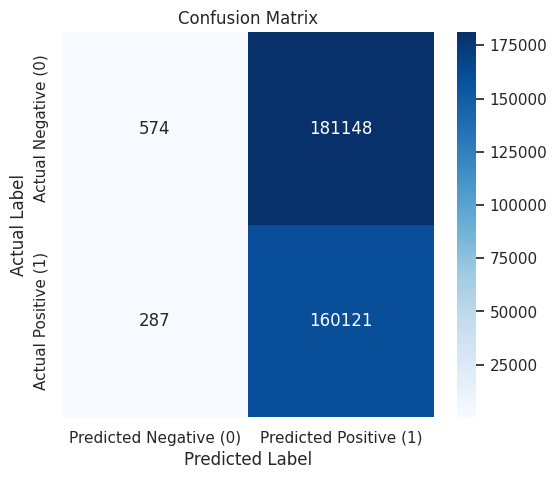

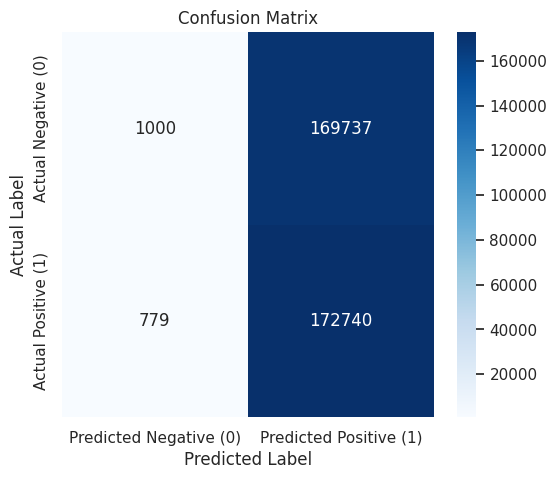

In [0]:
models = {'lr': baseline_model, 'xgb': xgb_model, 'mlp': mlp_model}

results = cross_validate_with_blocked_time_series_split_ensemble(models, df_train_downsampled, n_splits=5,pred_type='any_prediction')

In [0]:
print(results)

{'ensemble': {'precision': 0.49700444655194254, 'recall': 0.9964783642142041, 'f1_score': 0.6613844566850641, 'f2_score': 0.8273500460082399, 'roc_auc': 0.5008055538259358, 'pr_auc': 0.49791611738340097}}


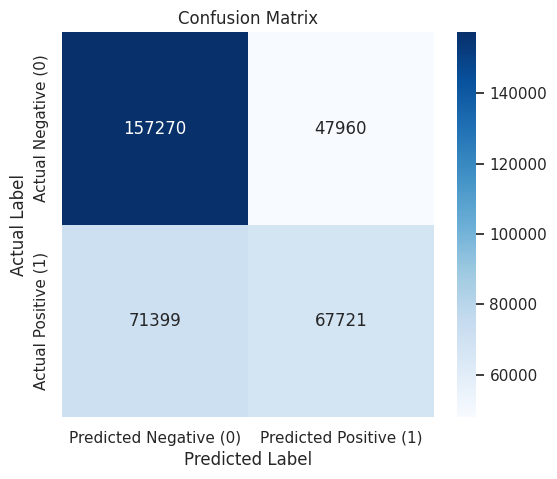

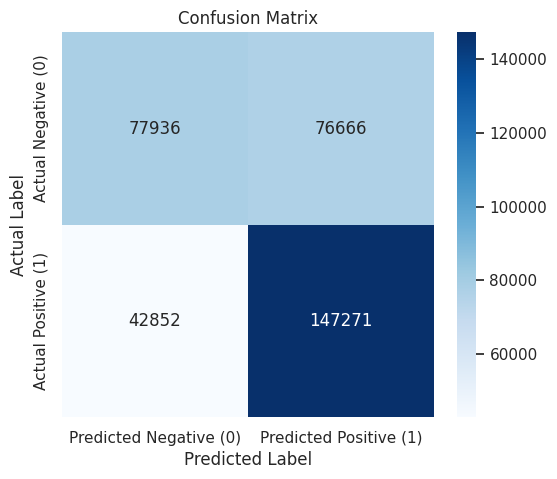

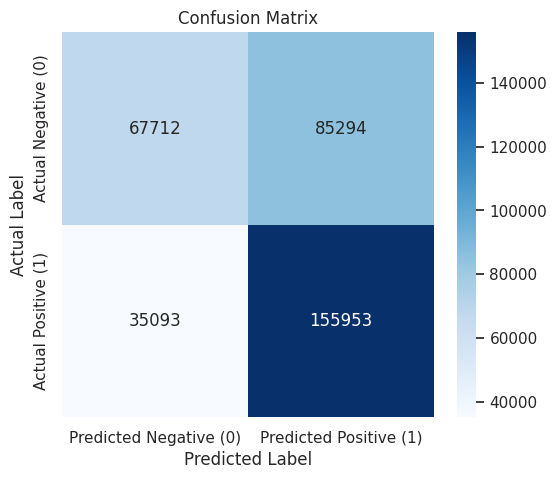

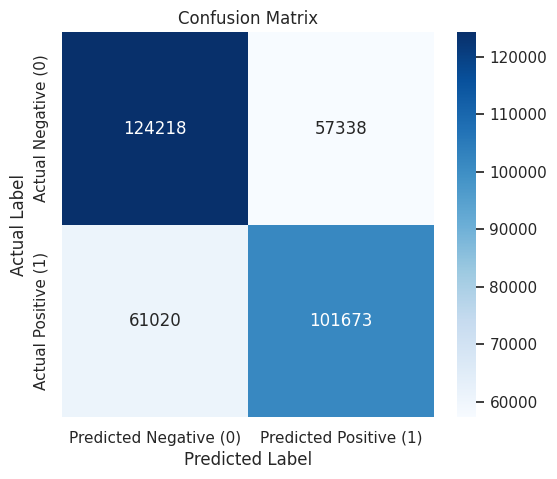

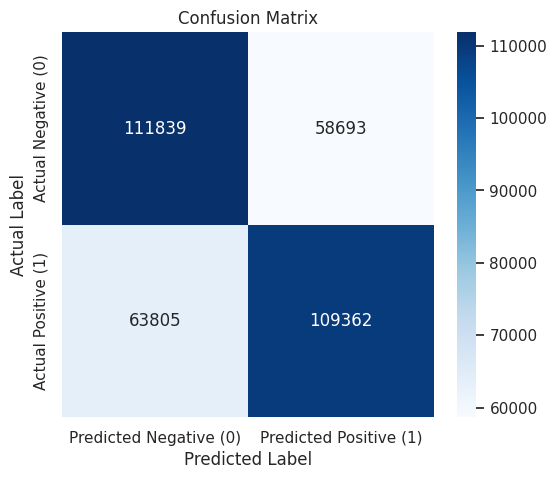

In [0]:
results = cross_validate_with_blocked_time_series_split_ensemble(models, df_train_downsampled, n_splits=5,pred_type='majority_prediction')

In [0]:
print(results)

{'ensemble': {'precision': 0.6359323142007131, 'recall': 0.6668359875137522, 'f1_score': 0.6475037236239126, 'f2_score': 0.6580763394057182, 'roc_auc': 0.6390471547028855, 'pr_auc': 0.6110757966890618}}


# Final Evaluation Ensemble

In [0]:
# add unique id to df_train_downsampled
df_train_downsampled = df_train_downsampled.withColumn("id", monotonically_increasing_id())

In [0]:
# Start with baseline (LR) model
lr_train_predictions = baseline_model.transform(df_train_downsampled).withColumnRenamed("prediction", "lr_prediction")

# Add xgb model predictions
xgb_train_predictions = xgb_model.transform(df_train_downsampled).withColumnRenamed("prediction", "xgb_prediction")

# Add mlp model predictions
mlp_train_predictions = mlp_model.transform(df_train_downsampled).withColumnRenamed("prediction", "mlp_prediction")

In [0]:
# join lr_train_predictions and xgb_train_predictions
train_predictions_lr_xgb = lr_train_predictions.select('id', 'lr_prediction','DEP_DEL15').join(xgb_train_predictions.select('id', 'xgb_prediction'), on="id", how="inner").join(mlp_train_predictions.select('id', 'mlp_prediction'), on="id", how="inner")

In [0]:
train_predictions_lr_xgb.select("id", "lr_prediction", "xgb_prediction",'mlp_prediction', "DEP_DEL15").show(5)

+---+-------------+--------------+--------------+---------+
| id|lr_prediction|xgb_prediction|mlp_prediction|DEP_DEL15|
+---+-------------+--------------+--------------+---------+
| 24|          0.0|           1.0|           1.0|        1|
|120|          1.0|           0.0|           0.0|        1|
|346|          1.0|           0.0|           0.0|        1|
|435|          0.0|           1.0|           1.0|        1|
|707|          0.0|           1.0|           1.0|        1|
+---+-------------+--------------+--------------+---------+
only showing top 5 rows



In [0]:
# create new column in train_predictions_lr_xgb, if any model predicts delay, then predict delay
train_predictions_lr_xgb = train_predictions_lr_xgb.withColumn("any_prediction", when((col("lr_prediction") == 1) | (col("xgb_prediction") == 1) | (col("mlp_prediction") == 1), 1.0).otherwise(0.0))


# create majority_prediction column, if lr_prediction + xgb_prediction + mlp_prediction > 1 then predict 1
train_predictions_lr_xgb = train_predictions_lr_xgb.withColumn("majority_prediction", when((col("lr_prediction") + col("xgb_prediction") + col("mlp_prediction")) >= 2, 1.0).otherwise(0.0))

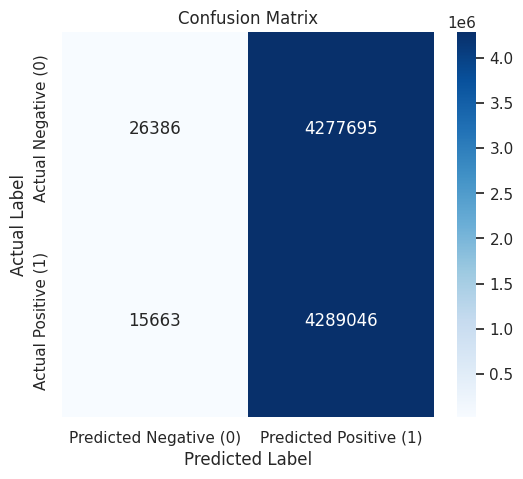

In [0]:
precision, recall, f1_score, f2_score, roc_auc, pr_auc = evaluate_ensembleOfEnsemble_model(train_predictions_lr_xgb, label_col="DEP_DEL15", prediction_col="any_prediction")

In [0]:
print(f2_score)

0.8316753974518392


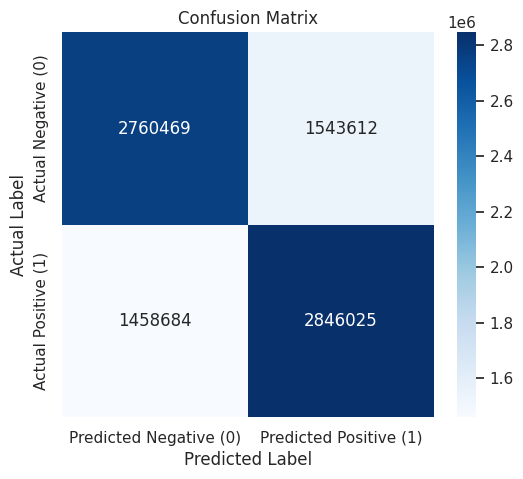

0.6585437573492583


In [0]:
precision, recall, f1_score, f2_score, roc_auc, pr_auc = evaluate_ensembleOfEnsemble_model(train_predictions_lr_xgb, label_col="DEP_DEL15", prediction_col="majority_prediction")

print(f2_score)

In [0]:
# add unique id to df_train_downsampled
df_test = df_test.withColumn("id", monotonically_increasing_id())
df_test = df_test.dropna()

In [0]:
# test predictions
# Start with baseline (LR) model
lr_test_predictions = baseline_model.transform(df_test).withColumnRenamed("prediction", "lr_prediction")

# Add xgb model predictions
xgb_test_predictions = xgb_model.transform(df_test).withColumnRenamed("prediction", "xgb_prediction")

# Add mlp model predictions
mlp_test_predictions = mlp_model.transform(df_test).withColumnRenamed("prediction", "mlp_prediction")

In [0]:
# join the three prediction columns
test_predictions_lr_xgb = lr_test_predictions.select('id', 'lr_prediction','DEP_DEL15').join(xgb_test_predictions.select('id', 'xgb_prediction'), on="id", how="inner").join(mlp_test_predictions.select('id', 'mlp_prediction'), on="id", how="inner")

In [0]:
# create new column in train_predictions_lr_xgb, if either lr_prediction or xgb_prediction is 1, set prediction to 1
test_predictions_lr_xgb = test_predictions_lr_xgb.withColumn("any_prediction", when((col("lr_prediction") == 1) | (col("xgb_prediction") == 1) | (col("mlp_prediction") == 1), 1.0).otherwise(0.0))

# create majority_prediction column, if lr_prediction + xgb_prediction + mlp_prediction > 1 then predict 1
test_predictions_lr_xgb = test_predictions_lr_xgb.withColumn("majority_prediction", when((col("lr_prediction") + col("xgb_prediction") + col("mlp_prediction")) >= 2, 1.0).otherwise(0.0))

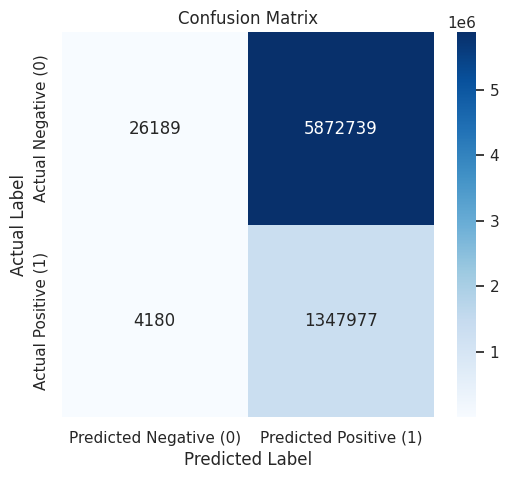

In [0]:
precision, recall, f1_score, f2_score, roc_auc, pr_auc = evaluate_ensembleOfEnsemble_model(test_predictions_lr_xgb, label_col="DEP_DEL15", prediction_col="any_prediction")

In [0]:
print(f2_score)

0.533668652940327


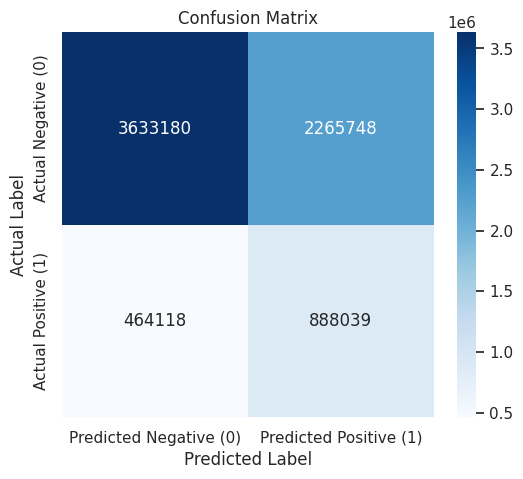

0.5185680675370208


In [0]:
precision, recall, f1_score, f2_score, roc_auc, pr_auc = evaluate_ensembleOfEnsemble_model(test_predictions_lr_xgb, label_col="DEP_DEL15", prediction_col="majority_prediction")

print(f2_score)